# Identify permitted and potentially unpermitted attached and detached units in San Jose (2020)

In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import math
from tqdm import tqdm

In [2]:
# Import functions for the polygon pipeline
%run ADU_permit_matching-polygon-pipeline.ipynb import (process_OSM_data, \
                                                        compare_buildings, \
                                                        merge_buildings,\
                                                        get_inference_main_building, \
                                                        identify_main_buildings, \
                                                        compute_largest_protruding_poly, \
                                                        compare_building_footprint, \
                                                        flatten_geometries, \
                                                        run_osm_apn, \
                                                        run_osm_apn_full_detail)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# File paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching')
SJ_RES_PARCELS_FP = os.path.join(INPUT_FP, 'inputs', 'san_jose_parcels_res.geojson')
ZONING_FP = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [5]:
# Load data
# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * Building permits
bldg_active = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_active.geojson'))
bldg_recent = gpd.read_file(os.path.join(INPUT_FP, 'inputs','permits', 'bldg_recent.geojson'))
bldg_expired = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_expired.geojson'))

# * Zoning
sj_zoning = gpd.read_file(ZONING_FP)
sj_residential = sj_zoning[(sj_zoning['ZONING'].str.contains('R-1')) | (sj_zoning['ZONING'].str.contains('R-2')) |\
         ((sj_zoning['ZONING'].str.contains('R-M')) & (sj_zoning['ZONING'] != 'R-MH'))]

# * parcel+permit
sj_parcel_permit = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])
sj_permit_noparcel['geometry'] = gpd.GeoSeries.from_wkt(sj_permit_noparcel['geometry'])

Handle active permits differently than expired permits
- Expired permits barely report dwelling units and square footage
- Should we filter really finely like we do for active permits, or filter for just work description as we do for expired permits to catch ALL the construction permits we can find? I worry that some of the buildings we infer will be under non-SFR permits

Keep this block of code in case we want to filter more specifically for possible dwelling units, but we will work with the more relaxed conditions to get more possible permits to compare to

In [6]:
# Filter permits
cols = list(bldg_active.columns) + ['permit_status']
permits = gpd.GeoDataFrame(columns=cols)
for i, status in zip([bldg_active, bldg_recent, bldg_expired], ['active', 'recent', 'expired']):
    i['permit_status'] = status
    permits = pd.concat([permits, i[i['WORKDESC'].isin(['New Construction', 'Additions/Alterations'])]])
permits = permits.reset_index(drop=True)

permits.crs = "EPSG:4326"

# Functions

In [7]:
def match_parcel(parcel_apn):
    # Obtain parcel-level data
    parcel_inputs = parcel_level_data(
      parcel_apn, sj_parcels_res, sj_parcel_permit)
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_inputs

    # Incorporate OSM data
    parcel_buildings, _ = process_OSM_data(
      inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, MIN_AREA_THRESHOLD, FLATTEN_THRESHOLD)

    # Incorporate permit data
    parcel_buildings = process_permit_data(parcel_apn, permits_parcel, parcel_buildings)

    return parcel_buildings

In [8]:
def parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # clip inferred buildings and osm buildings
    # i don't think clip is a good idea since it truncates the inferences according to the mask
    # inferred_buildings_2020_parcel = gpd.clip(building_inference_2020, parcel_bounds)

    # def mask_buildings(df, parcel_bounds):
    #   df_out = df.sjoin(parcel_bounds[['geometry','geom']])
    #   # print(df_out)
    #   df_out['iou'] = df_out['geometry'].intersection(df_out['geom']).area/df_out['geom'].area
    #   df_out = df_out[df_out['iou'] > 0.7]
    #   return df_out

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.7]
        if df_out.empty:
            return None
        else:
            return df_out

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

In [9]:
def process_permit_data(parcel_apn, permits_parcel, parcel_buildings):
    # filter by parcel_buildings in this first pass
    """
    We will only consider non-main buildings OR main buildings with a detected expansion from OSM or 2016.
    
    For each parcel, we will:
    1. Filter for parcels that are clearly not SFRs (has >5 buildings)
    
    There are three types of classifications:
    1. Permitted (building/activity matches to a permit)
        - If expansion, permit needs to be issued between 2015-2020
        - If small building, 
    2. Unpermitted (building/activity doesn't match reasonably to a permit)
    """
    if parcel_buildings is not None:
        if len(parcel_buildings) <= 5:
            # then consider
            parcel_buildings = parcel_buildings[(parcel_buildings['main_building_flag'] == False) | \
                                                ((parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag'])))]
            if not parcel_buildings.empty:
                # then start to do matching
                if permits_parcel is not None and len(permits_parcel) > 0:
                    ## ------ MAIN DRIVER HERE ------
                    output_df = gpd.GeoDataFrame(columns=['apn'] + list(parcel_buildings.columns) + ['verdict', 'permit_id', 'certainty'])
                    permit_nomatch_df = pd.DataFrame(columns=permits_parcel.columns)
                    
                    # then there is a permit matching in that parcel
                    small_building = parcel_buildings[parcel_buildings['main_building_flag'] == False].reset_index(drop=True)
                    expansion = parcel_buildings[(parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag']))].reset_index(drop=True)
                    
                    
                    if not expansion.empty:
                        assert len(expansion) == 1
                        
                        
                    for idx, row in permits_parcel.iterrows():
                        if row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['DWELLINGUNIT'] > 0 and \
                        row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations'):
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                            # then try to find the expansion
                        else:
                            print(row[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'year']])
                            # add to unmatched permits -- probably permits never went through or FN from model
                    
                    # rest is unpermitted
                    if not small_building.empty:
                        small_building['verdict'] = 'unpermitted'
                        small_building['apn'] = parcel_apn
                        output_df = pd.concat([output_df, small_building])
                        
                    if not expansion.empty:
                        expansion['verdict'] = 'unpermitted'
                        expansion['apn'] = parcel_apn
                        output_df = pd.concat([output_df, expansion])
                        
                    return output_df, permit_nomatch_df
#                     if not expansion.empty:
#                         print(expansion)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                        
#                     if not small_building.empty:
#                         print(small_building)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                    
                        
                else:
                    # return all the filtered parcel_buildings, with the caveat that we're highly overestimating
                    parcel_buildings['verdict'] = 'unpermitted'
                    parcel_buildings['apn'] = parcel_apn
                    return parcel_buildings, None
            else:
                # return nothing since we can't consider any of the buildings (at least not rn)
#                 if permits_parcel is not None and len(permits_parcel) > 0:
#                     return None, permits_parcel
#                 else:
#                     return None, None
                return None, None
        else:
            # return nothing since we don't want to consider this parcel
            return None, None
    
#     if len(permits_parcel) > 0:
#         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
#         if parcel_buildings is not None:
#             print(parcel_buildings)
#         else:
#             print(0)
#         pass
#     else:
#         return parcel_buildings

In [10]:
def process_permit_data(parcel_apn, permits_parcel, parcel_buildings):
    # filter by parcel_buildings in this first pass
    """
    We will only consider non-main buildings OR main buildings with a detected expansion from OSM or 2016.
    
    For each parcel, we will:
    1. Filter for parcels that are clearly not SFRs (has >5 buildings)
    
    There are three types of classifications:
    1. Permitted (building/activity matches to a permit)
        - If expansion, permit needs to be issued between 2015-2020
        - If small building, 
    2. Unpermitted (building/activity doesn't match reasonably to a permit)
    """
    if parcel_buildings is not None:
        if len(parcel_buildings) <= 5:
            # then consider
            parcel_buildings = parcel_buildings[(parcel_buildings['main_building_flag'] == False) | \
                                                ((parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag'])))]
            # Non-empty parcel buildings
            if not parcel_buildings.empty:
                # then start to do matching
                if permits_parcel is not None and len(permits_parcel) > 0:
                    ## ------ MAIN DRIVER HERE ------
                    output_df = gpd.GeoDataFrame(columns=['apn'] + list(parcel_buildings.columns) + ['verdict', 'permit_id', 'certainty'])
                    permit_nomatch_df = pd.DataFrame(columns=permits_parcel.columns)
                    
                    # then there is a permit matching in that parcel
                    small_building = parcel_buildings[parcel_buildings['main_building_flag'] == False].reset_index(drop=True)
                    expansion = parcel_buildings[(parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag']))].reset_index(drop=True)
                    
                    
                    if not expansion.empty:
                        assert len(expansion) == 1
                        
                    # Loop over the permits in the parcel 
                    for idx, row in permits_parcel.iterrows():
                        # Main building expansion permits (2015-2020) - positive square footage (higher risk)
                        if row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Main building expansion permits (2015-2020) - non-positive square footage (lower risk)
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Main building expansion permits (2015-2020) - non-positive square footage and permit value (lowest risk)
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Other alterations/construction - higher risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['DWELLINGUNIT'] > 0 and \
                        row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        #  Other alterations/construction - lower risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        #  Other alterations/construction - lowest risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations'):
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                            # then try to find the expansion
                        else:
                            print(row[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'year']])
                            # add to unmatched permits -- probably permits never went through or FN from model
                    
                    # Mark remaining buildings as unpermitted
                    # rest is unpermitted
                    if not small_building.empty:
                        small_building['verdict'] = 'unpermitted'
                        small_building['apn'] = parcel_apn
                        output_df = pd.concat([output_df, small_building])
                        
                    if not expansion.empty:
                        expansion['verdict'] = 'unpermitted'
                        expansion['apn'] = parcel_apn
                        output_df = pd.concat([output_df, expansion])
                        
                    return output_df, permit_nomatch_df
#                     if not expansion.empty:
#                         print(expansion)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                        
#                     if not small_building.empty:
#                         print(small_building)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                    
                # Empty permits        
                else:
                    # return all the filtered parcel_buildings, with the caveat that we're highly overestimating
                    parcel_buildings['verdict'] = 'unpermitted'
                    parcel_buildings['apn'] = parcel_apn
                    return parcel_buildings, None
                
            # Empty buildings
            else:
                # return nothing since we can't consider any of the buildings (at least not rn)
                return None, None

        # Non-residential parcel (>5 buildings)
        else:
            # return nothing since we don't want to consider this parcel
            return None, None

# Main

In [23]:
if os.path.exists('shortlist.csv'):
    shortlist = pd.read_csv('shortlist.csv')
else:
    shortlist = pd.DataFrame(columns=['apn', 'main_building_flag', 'OSM_flag', 
                                      'expansion_OSM_flag', 'expansion_2016_flag', 
                                      'geometry', 'verdict', 'permit_id', 'certainty'])
    
if os.path.exists('permit_nomatch.csv'):
    permit_nomatch = pd.read_csv('permit_nomatch.csv')
else:
    permit_nomatch = pd.DataFrame()

In [41]:
# Loop over each parcel
parcel_apns = sj_parcels_res['APN'].unique()

idx = 0
for parcel_apn in tqdm(parcel_apns):
    # Run the condition below if you want to filter only on permits that match to a parcel
#    if not sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn].empty:
    shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
    if shortlist_parcel is not None and len(shortlist_parcel) > 0:
        shortlist = pd.concat([shortlist, shortlist_parcel])
    if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
        permit_nomatch = pd.concat([permit_nomatch, permit_nomatch_df]) 
    idx += 1
    if idx % 100 == 0:
        shortlist.to_csv('shortlist.csv', index=False)
        permit_nomatch.to_csv('permit_nomatch.csv', index=False)

100%|██████████| 100/100 [05:54<00:00,  3.55s/it]


## Balanced sampling over parcels

In [11]:
MIN_AREA_THRESHOLD = 30
FLATTEN_THRESHOLD = 0.85
SAMPLE_SIZE = 1000

In [75]:
# Loop over each parcel
parcel_apns = sj_parcels_res['APN'].unique()

# Set up parcels that match and don't match to permits
shortlist_cols = ['apn', 'main_building_flag', 'OSM_flag', 'expansion_OSM_flag', 
                  'expansion_2016_flag', 'geometry', 'verdict', 'permit_id', 'certainty']
perm_shortlist = pd.DataFrame(columns=shortlist_cols)
unperm_shortlist = pd.DataFrame(columns=shortlist_cols)

perm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)
unperm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)
reviewed_perm_apns, reviewed_unperm_apns = [], []

if os.path.exists('perm_shortlist.csv'):
    try:
        perm_shortlist = pd.read_csv('perm_shortlist.csv')
    except pd.errors.EmptyDataError:
        perm_shortlist = pd.DataFrame(columns=shortlist_cols)
        
    try:
        unperm_shortlist = pd.read_csv('unperm_shortlist.csv')
    except pd.errors.EmptyDataError:
        unperm_shortlist = pd.DataFrame(columns=shortlist_cols)
        
    try:
        perm_permit_nomatch = pd.read_csv('perm_permit_nomatch.csv')
    except pd.errors.EmptyDataError:
        perm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)
    
    try:
        unperm_permit_nomatch = pd.read_csv('unperm_permit_nomatch.csv')
    except pd.errors.EmptyDataError:
        unperm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)
    
    reviewed_perm_apns = set(perm_shortlist['apn'].unique()) 
    reviewed_perm_apns = reviewed_perm_apns.union(set(perm_permit_nomatch['APN_parcel'].unique()))
    
    reviewed_unperm_apns = set(unperm_shortlist['apn'].unique())
    reviewed_unperm_apns = reviewed_unperm_apns.union(set(unperm_permit_nomatch['APN_parcel'].unique()))

np.random.seed(43)
parcel_apns = np.random.choice(parcel_apns, len(parcel_apns), replace=False)

print('Reviewed permitted APNs: {}; Reviewed unpermitted APNs: {}'.format(len(reviewed_perm_apns), len(reviewed_unperm_apns)))


for i, parcel_apn in tqdm(enumerate(parcel_apns)):
    if parcel_apn in reviewed_apns:
        continue
        
    count_perm = len(perm_shortlist['apn'].unique())
    count_unperm = len(unperm_shortlist['apn'].unique())
        
    if count_perm >= SAMPLE_SIZE and count_unperm >= SAMPLE_SIZE:
        break
    
    # Filter only on permits that match to a parcel
    if not sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn].empty:
        if count_perm < SAMPLE_SIZE:
            shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
            if shortlist_parcel is not None and len(shortlist_parcel) > 0:
                perm_shortlist = pd.concat([perm_shortlist, shortlist_parcel])
            if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
                perm_permit_nomatch = pd.concat([perm_permit_nomatch, permit_nomatch_df]) 
        else:
            continue
    else:
        if count_unperm < SAMPLE_SIZE:
            shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
            if shortlist_parcel is not None and len(shortlist_parcel) > 0:
                unperm_shortlist = pd.concat([unperm_shortlist, shortlist_parcel])
            if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
                unperm_permit_nomatch = pd.concat([unperm_permit_nomatch, permit_nomatch_df]) 
        else:
            continue
    
    if i % 50 == 0:
        print("Permitted: {}; Unpermitted: {}".format(count_perm, count_unperm))
        perm_shortlist.to_csv('perm_shortlist.csv', index=False)
        unperm_shortlist.to_csv('unperm_shortlist.csv', index=False)
        perm_permit_nomatch.to_csv('perm_permit_nomatch.csv', index=False)
        unperm_permit_nomatch.to_csv('unperm_permit_nomatch.csv', index=False)

print("Permitted: {}; Unpermitted: {}".format(count_perm, count_unperm))
perm_shortlist.to_csv('perm_shortlist.csv', index=False)
unperm_shortlist.to_csv('unperm_shortlist.csv', index=False)
perm_permit_nomatch.to_csv('perm_permit_nomatch.csv', index=False)
unperm_permit_nomatch.to_csv('unperm_permit_nomatch.csv', index=False)

Reviewed permitted APNs: 1000; Reviewed unpermitted APNs: 1000


1it [00:25, 25.34s/it]

Permitted: 559; Unpermitted: 474


50it [02:00,  2.08s/it]

Permitted: 559; Unpermitted: 474


100it [03:28,  1.74s/it]

Permitted: 559; Unpermitted: 474


150it [05:01,  1.80s/it]

Permitted: 559; Unpermitted: 474


200it [06:58,  2.12s/it]

Permitted: 559; Unpermitted: 474


250it [08:34,  1.58s/it]

Permitted: 559; Unpermitted: 474


300it [10:07,  1.67s/it]

Permitted: 559; Unpermitted: 474


350it [11:39,  1.58s/it]

Permitted: 559; Unpermitted: 474


400it [13:26,  1.65s/it]

Permitted: 559; Unpermitted: 474


450it [14:53,  1.58s/it]

Permitted: 559; Unpermitted: 474


500it [16:32,  2.11s/it]

Permitted: 559; Unpermitted: 474


550it [18:03,  1.60s/it]

Permitted: 559; Unpermitted: 474


600it [19:47,  1.89s/it]

Permitted: 559; Unpermitted: 474


650it [21:59, 10.63s/it]

Permitted: 559; Unpermitted: 474


700it [23:32,  1.95s/it]

Permitted: 559; Unpermitted: 474


750it [25:10,  2.21s/it]

Permitted: 559; Unpermitted: 474


800it [27:06,  1.91s/it]

Permitted: 559; Unpermitted: 474


850it [28:38,  1.98s/it]

Permitted: 559; Unpermitted: 474


900it [30:17,  1.89s/it]

Permitted: 559; Unpermitted: 474


950it [31:50,  1.88s/it]

Permitted: 559; Unpermitted: 474


1000it [33:23,  2.05s/it]

Permitted: 559; Unpermitted: 474


1050it [34:59,  1.89s/it]

Permitted: 559; Unpermitted: 485


1100it [37:27,  2.21s/it]

Permitted: 559; Unpermitted: 506


1150it [39:16,  1.66s/it]

Permitted: 559; Unpermitted: 528


1200it [40:52,  1.68s/it]

Permitted: 559; Unpermitted: 543


1250it [42:29,  1.87s/it]

Permitted: 559; Unpermitted: 565


1300it [44:02,  1.55s/it]

Permitted: 559; Unpermitted: 578


1350it [45:27,  1.26s/it]

Permitted: 559; Unpermitted: 599


1400it [46:56,  1.55s/it]

Permitted: 559; Unpermitted: 624


1450it [48:34,  1.94s/it]

Permitted: 559; Unpermitted: 649


1500it [50:09,  2.02s/it]

Permitted: 559; Unpermitted: 670


1550it [51:51,  2.11s/it]

Permitted: 559; Unpermitted: 692


1600it [53:23,  1.73s/it]

Permitted: 559; Unpermitted: 712


1650it [54:59,  1.98s/it]

Permitted: 559; Unpermitted: 739


1700it [56:28,  1.36s/it]

Permitted: 559; Unpermitted: 756


1750it [58:04,  1.68s/it]

Permitted: 559; Unpermitted: 774


1800it [59:47,  1.71s/it]

Permitted: 559; Unpermitted: 799


1850it [1:01:18,  1.98s/it]

Permitted: 559; Unpermitted: 825


1900it [1:02:54,  1.89s/it]

Permitted: 559; Unpermitted: 850


1950it [1:04:24,  1.80s/it]

Permitted: 559; Unpermitted: 870


2000it [1:06:01,  1.67s/it]

Permitted: 559; Unpermitted: 894


2050it [1:07:37,  2.03s/it]

Permitted: 559; Unpermitted: 913


2100it [1:09:14,  2.03s/it]

Permitted: 559; Unpermitted: 934


2150it [1:10:52,  1.81s/it]

Permitted: 559; Unpermitted: 963


2200it [1:13:30,  1.53s/it]

Permitted: 559; Unpermitted: 981


2543it [1:15:35,  3.20it/s]

Permitted: 559; Unpermitted: 1000


2849it [1:16:17,  9.31it/s]

Permitted: 559; Unpermitted: 1000


3049it [1:16:42,  7.24it/s]

Permitted: 559; Unpermitted: 1000


3512it [1:18:50,  9.51it/s]

Permitted: 559; Unpermitted: 1000


3615it [1:18:58, 11.66it/s]

Permitted: 559; Unpermitted: 1000


4197it [1:19:49,  7.71it/s]

Permitted: 559; Unpermitted: 1000


6212it [1:24:57,  3.73it/s]

Permitted: 559; Unpermitted: 1000


7939it [1:28:23,  9.39it/s]

Permitted: 559; Unpermitted: 1000


8549it [1:29:31,  3.73it/s]

Permitted: 559; Unpermitted: 1000


8625it [1:29:42,  7.15it/s]

Permitted: 559; Unpermitted: 1000


8847it [1:30:12,  4.28it/s]

Permitted: 559; Unpermitted: 1000


10057it [1:32:47,  5.62it/s]

Permitted: 559; Unpermitted: 1000


10895it [1:34:51,  5.96it/s]

Permitted: 559; Unpermitted: 1000


11335it [1:35:44,  9.93it/s]

Permitted: 559; Unpermitted: 1000


12796it [1:38:27,  5.21it/s]

Permitted: 559; Unpermitted: 1000


12944it [1:38:38, 11.93it/s]

Permitted: 559; Unpermitted: 1000


13094it [1:38:54, 19.22it/s]

Permitted: 559; Unpermitted: 1000


13686it [1:39:58,  8.91it/s]

Permitted: 559; Unpermitted: 1000


15594it [1:47:25,  9.33it/s]

Permitted: 559; Unpermitted: 1000


15864it [1:47:53, 12.41it/s]

Permitted: 559; Unpermitted: 1000


16312it [1:48:45,  5.83it/s]

Permitted: 559; Unpermitted: 1000


19333it [1:54:26,  5.95it/s]

Permitted: 573; Unpermitted: 1000


19482it [1:54:50,  4.62it/s]

Permitted: 580; Unpermitted: 1000


20439it [1:56:19, 13.22it/s]

Permitted: 607; Unpermitted: 1000


20942it [1:57:17,  6.79it/s]

Permitted: 623; Unpermitted: 1000


22233it [2:00:21, 10.29it/s]

Permitted: 660; Unpermitted: 1000


22541it [2:00:37, 20.22it/s]

Permitted: 663; Unpermitted: 1000


23247it [2:02:11,  6.38it/s]

Permitted: 691; Unpermitted: 1000


25532it [2:06:40,  8.23it/s]

Permitted: 764; Unpermitted: 1000


26091it [2:07:36, 11.34it/s]

Permitted: 781; Unpermitted: 1000


27143it [2:09:15, 17.75it/s]

Permitted: 806; Unpermitted: 1000


27335it [2:09:34, 20.15it/s]

Permitted: 810; Unpermitted: 1000


27948it [2:10:46, 12.70it/s]

Permitted: 825; Unpermitted: 1000


28374it [2:17:38,  3.85s/it]

Permitted: 847; Unpermitted: 1000


28445it [2:17:50,  1.64it/s]

Permitted: 849; Unpermitted: 1000


29907it [2:20:31,  9.05it/s]

Permitted: 895; Unpermitted: 1000


30876it [2:25:23,  1.97s/it]

Permitted: 925; Unpermitted: 1000


31189it [2:26:03,  6.50it/s]

Permitted: 936; Unpermitted: 1000


31297it [2:26:16, 11.29it/s]

Permitted: 938; Unpermitted: 1000


31638it [2:27:03,  8.39it/s]

Permitted: 951; Unpermitted: 1000


31866it [2:27:37,  5.04it/s]

Permitted: 958; Unpermitted: 1000


31987it [2:27:50, 10.12it/s]

Permitted: 960; Unpermitted: 1000


33074it [2:30:40, 11.20it/s]

Permitted: 988; Unpermitted: 1000


33497it [2:31:28, 11.74it/s]

Permitted: 999; Unpermitted: 1000


33501it [2:31:31,  3.68it/s]


Permitted: 1000; Unpermitted: 1000


In [12]:
# Read in data
try:
    perm_shortlist = pd.read_csv('perm_shortlist.csv')
except pd.errors.EmptyDataError:
    perm_shortlist = pd.DataFrame(columns=shortlist_cols)

try:
    unperm_shortlist = pd.read_csv('unperm_shortlist.csv')
except pd.errors.EmptyDataError:
    unperm_shortlist = pd.DataFrame(columns=shortlist_cols)

try:
    perm_permit_nomatch = pd.read_csv('perm_permit_nomatch.csv')
except pd.errors.EmptyDataError:
    perm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)

try:
    unperm_permit_nomatch = pd.read_csv('unperm_permit_nomatch.csv')
except pd.errors.EmptyDataError:
    unperm_permit_nomatch = pd.DataFrame(columns=sj_parcel_permit.columns)

assert len(perm_shortlist['apn'].unique()) == SAMPLE_SIZE
assert len(unperm_shortlist['apn'].unique()) == SAMPLE_SIZE

In [13]:
# Grab first 1k parcels of each type
perm_shortlist['shortlist_type'] = 'permitted'
unperm_shortlist['shortlist_type'] = 'unpermitted'

perm_permit_nomatch['shortlist_type'] = 'permitted'
unperm_permit_nomatch['shortlist_type'] = 'unpermitted'

perm_apns = perm_shortlist['apn'].unique()
perm_apns = np.random.choice(perm_apns, size=1000, replace=False)

unperm_apns = unperm_shortlist['apn'].unique()
unperm_apns = np.random.choice(unperm_apns, size=1000, replace=False)

shortlist = pd.concat([perm_shortlist.loc[perm_shortlist['apn'].isin(perm_apns)], 
                       unperm_shortlist.loc[unperm_shortlist['apn'].isin(unperm_apns)]])

permit_nomatch = pd.concat([perm_permit_nomatch.loc[perm_permit_nomatch['APN_parcel'].isin(perm_apns)], 
                            unperm_permit_nomatch.loc[unperm_permit_nomatch['APN_parcel'].isin(unperm_apns)]])

# Drop duplicates
permit_nomatch = permit_nomatch.drop_duplicates()
shortlist = shortlist.drop_duplicates()

In [14]:
# Compute stats
shortlist['expansion_flag'] = shortlist['expansion_2016_flag'] | shortlist['expansion_OSM_flag']
shortlist.groupby(['shortlist_type', 'verdict', 'main_building_flag', 'expansion_2016_flag'])['apn'].count()

shortlist_type  verdict      main_building_flag  expansion_2016_flag
permitted       permitted    False               False                  207
                                                 True                   180
                             True                False                    6
                                                 True                   316
                unpermitted  False               False                  111
                                                 True                   167
                             True                False                   25
                                                 True                   414
unpermitted     unpermitted  False               False                  255
                                                 True                   240
                             True                False                   33
                                                 True                   728
Name: apn, dtype: i

In [15]:
permit_nomatch.groupby(['shortlist_type'])['APN_parcel'].count()

shortlist_type
permitted    459
Name: APN_parcel, dtype: int64

In [31]:
len(sj_parcel_permit['APN_parcel'].unique())

11456

In [55]:
permit_nomatch = permit_nomatch.drop_duplicates()

In [57]:
len(shortlist)

2738

In [71]:
# Look at unmatched permits
# Filter for permits after 2015
permit_nomatch_16_20 = permit_nomatch.loc[(permit_nomatch['year'] >= 2016) & (permit_nomatch['year'] <= 2020)]

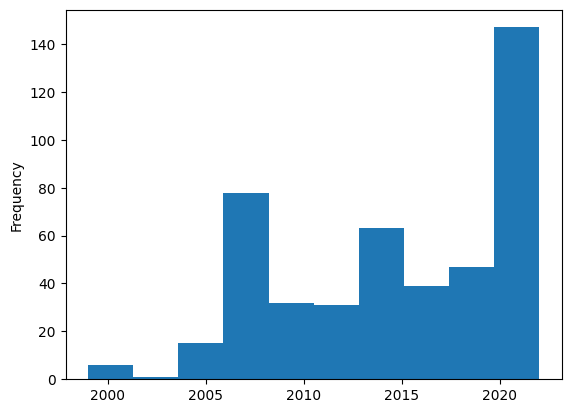

In [68]:
permit_nomatch['year'].plot.hist()
plt.show()

In [72]:
len(permit_nomatch_16_20)

94

In [78]:
permit_nomatch_16_20.iloc[1]

In [76]:
sj_parcel_permit[sj_parcel_permit['APN_parcel'] == '27406055'][[
    'OBJECTID_left', 'WORKDESC', 'SUBDESC', 'FOLDERNUM', 'permit_status', 'PERMITVALUE',
    'DWELLINGUNIT', 'SQUAREFOOT']]

,OBJECTID_left,WORKDESC,SUBDESC,FOLDERNUM,permit_status,PERMITVALUE,DWELLINGUNIT,SQUAREFOOT
11477,E_42433,Additions/Alterations,Single-Family,2018-135213-RS,expired,1224.0,0,0
11848,E_45244,Additions/Alterations,Single-Family,2018-114830-RS,expired,25616.0,0,0


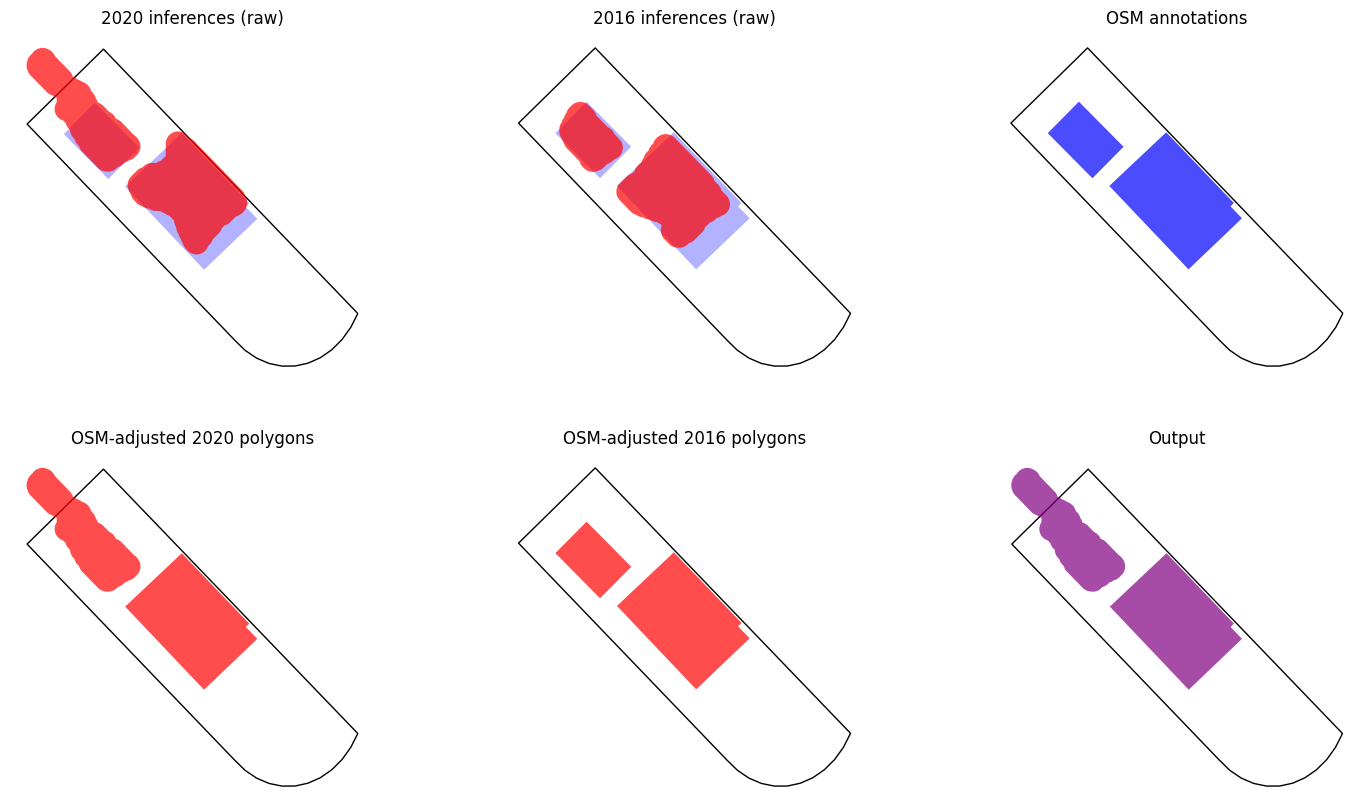

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,area
0,True,True,False,True,"POLYGON ((-121.93138 37.33552, -121.93129 37.3...",152.201468
2,False,False,True,True,"POLYGON ((-121.93152 37.33566, -121.93152 37.3...",95.734520


In [77]:
run_osm_apn_full_detail(parcel_apn='27406055', area_threshold=30, flatten_threshold=0.80)

In [28]:
# Look at small building constructions -- are these mostly false positives?
shortlist.loc[(shortlist['main_building_flag'] == False) & (shortlist['expansion_2016_flag'] == True)].head(5)

,apn,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,verdict,permit_id,certainty,area,shortlist_type,expansion_flag
13,27408009,False,True,False,True,"POLYGON ((-121.926437 37.335341, -121.926441 3...",permitted,A_51602,3.0,37.093952,permitted,True
14,27408009,False,False,True,True,POLYGON ((-121.9266223884396 37.33530497938542...,permitted,A_56785,3.0,22.151059,permitted,True
16,27408009,False,False,True,True,"POLYGON ((-121.9269782775079 37.3355311321258,...",unpermitted,NaN,NaN,15.796815,permitted,True
19,42937040,False,True,False,True,"POLYGON ((-121.905101 37.298959, -121.904946 3...",permitted,E_23766,3.0,76.659214,permitted,True
24,46702025,False,True,False,True,"POLYGON ((-121.888681 37.342105, -121.888729 3...",permitted,E_23609,3.0,90.897816,permitted,True


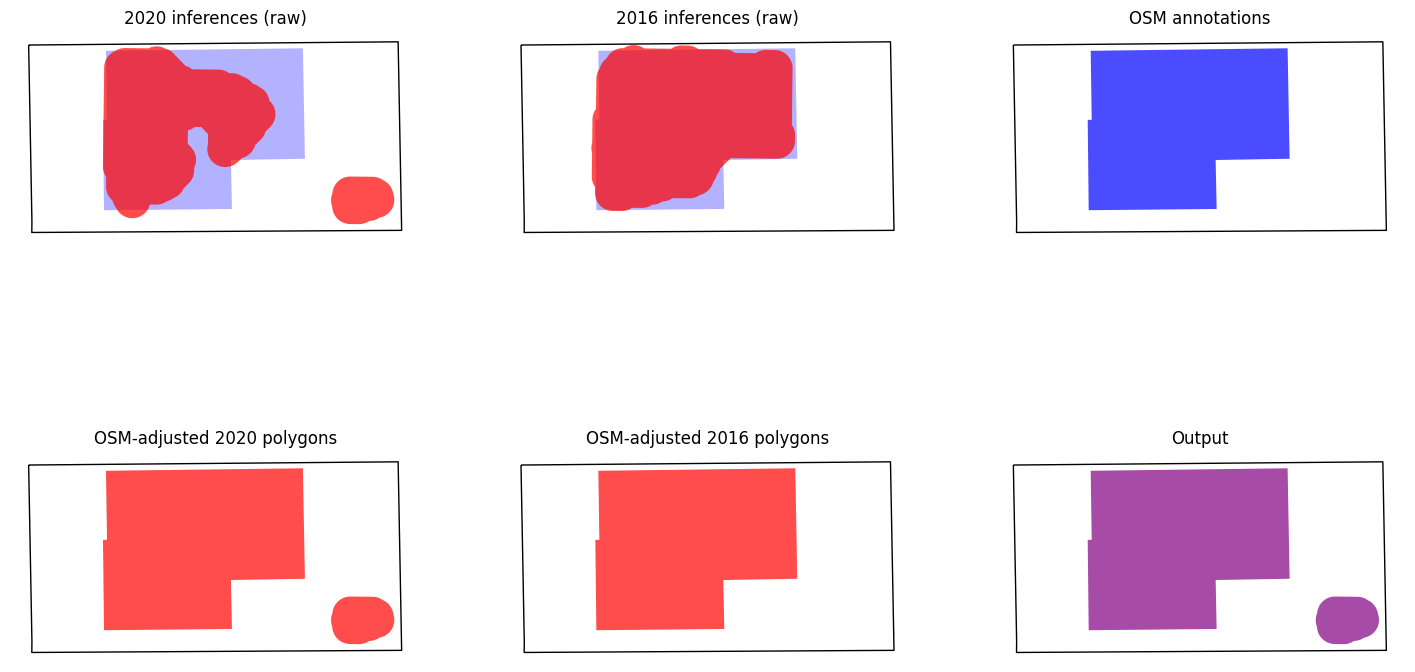

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,area
0,True,True,False,True,"POLYGON ((-121.80660 37.23220, -121.80660 37.2...",221.457161
1,False,False,True,True,"POLYGON ((-121.80637 37.23214, -121.80637 37.2...",19.499806


In [27]:
# Ground truth
run_osm_apn_full_detail(parcel_apn='68932067', area_threshold=30, flatten_threshold=0.85)

In [51]:
# Look at main building expansions
shortlist.loc[(shortlist['main_building_flag'] == True)].iloc[15:20]

,apn,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,verdict,permit_id,certainty,area,shortlist_type,expansion_flag
29,42116035,True,True,False,True,"POLYGON ((-121.941429 37.24766699999999, -121....",unpermitted,NaN,NaN,269.904643,permitted,True
32,70618043,True,False,True,True,"POLYGON ((-121.762107995041 37.22864553960805,...",unpermitted,NaN,NaN,226.279209,permitted,True
33,24509050,True,False,True,True,"POLYGON ((-121.870066601121 37.38328890274084,...",unpermitted,NaN,NaN,237.600107,permitted,True
36,26444013,True,True,False,True,"POLYGON ((-121.900203 37.317151, -121.900202 3...",unpermitted,NaN,NaN,139.015718,permitted,True
37,26140107,True,False,True,True,POLYGON ((-121.9081484043368 37.32441501705095...,unpermitted,NaN,NaN,135.353035,permitted,True


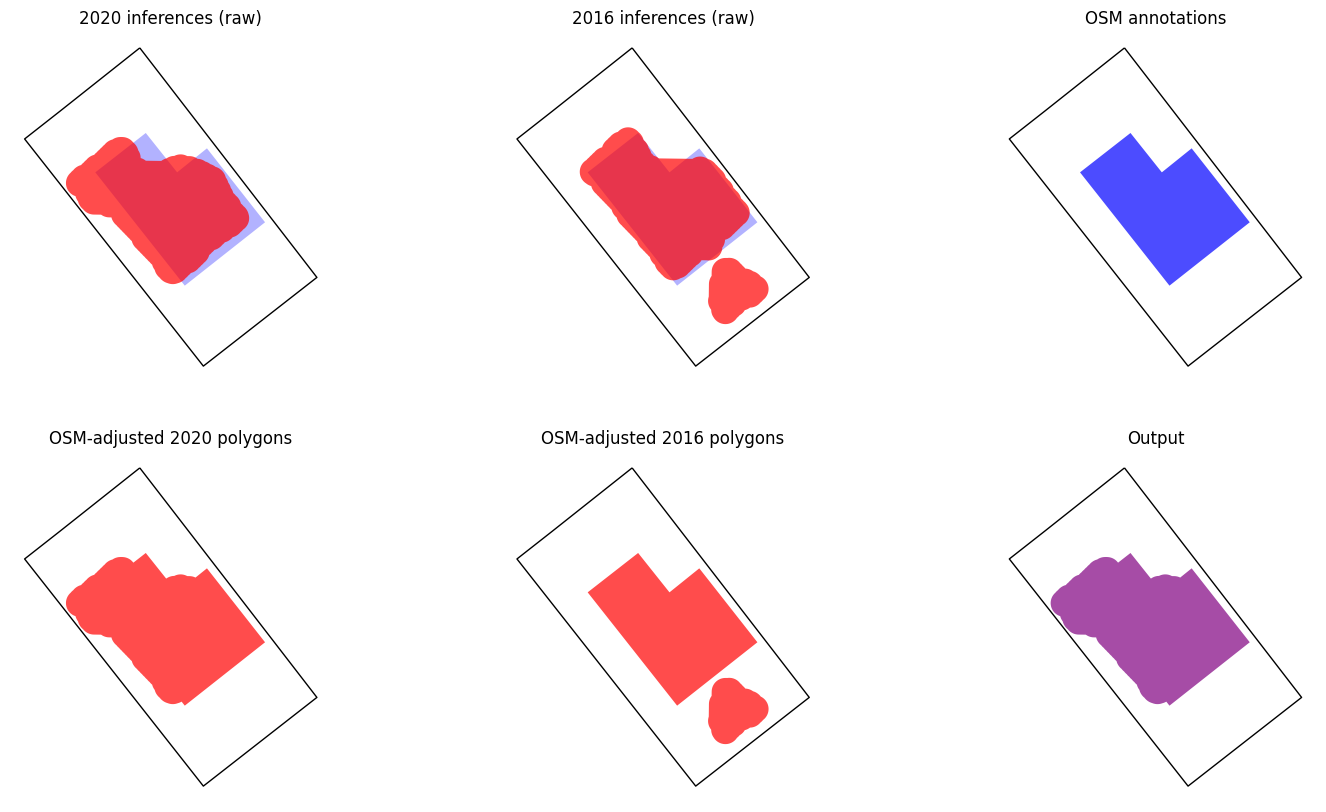

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,area
1,True,False,True,True,"POLYGON ((-121.76211 37.22865, -121.76211 37.2...",226.279209


In [54]:
run_osm_apn_full_detail(parcel_apn='70618043', area_threshold=30, flatten_threshold=0.85)

In [26]:
# Check
#parcel_apn='48114037'
#inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
#parcel_buildings = process_OSM_data(
#    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel)

In [2]:
# 3.5 Sort shortlists
# TO DO
# Risk levels:
# highest risk, no permitted additions of any kind, and you detect detached
# no permitted additions of any kind, and you detect attached
# permitted detached ADU, you detect more than one detached
# permitted detached ADU, you detect attached and detached
# permitted attached ADU, you detect attached and detached
# permitted attached ADU, you detect a detached (or vice versa)
# permitted attached ADU and detached ADU, you detect anything unpermitted